# ETL & EDA

## Librerías Utilizadas

In [1]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport

import warnings 
warnings.filterwarnings("ignore")

import gc

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

sns.set_theme(palette="muted")

from sklearn.linear_model import LinearRegression
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

---
- Carga de datos

In [ ]:
# Yellow Taxi Tripdata
df_YT = pd.read_parquet(r'..\..\datasets\1. Originales\TLC Trip Record Data\yellow_tripdata_2021-01.parquet')
# Green Taxi Tripdata
df_GT = pd.read_parquet(r'..\..\datasets\1. Originales\TLC Trip Record Data\green_tripdata_2021-01.parquet')
# FHV - High Volume
df_FHVHV = pd.read_parquet(r'..\..\datasets\1. Originales\TLC Trip Record Data\fhvhv_tripdata_2021-01.parquet')
# FHV - Other
df_FHV = pd.read_parquet(r'..\..\datasets\1. Originales\TLC Trip Record Data\fhv_tripdata_2021-01.parquet')

- Se verifica la cantidad de duplicados previo al procesamiento

In [3]:
# Mostrar el resultado
print(df_YT.duplicated().sum())
print(df_GT.duplicated().sum())
print(df_FHVHV.duplicated().sum())
print(df_FHV.duplicated().sum())

0
0
26
2059


In [4]:
# Eliminar datos duplicados
df_YT = df_YT.drop_duplicates()
df_GT = df_GT.drop_duplicates()
df_FHVHV = df_FHVHV.drop_duplicates()
df_FHV = df_FHV.drop_duplicates()

- Se renombrarn las columnas de cada DF para que coincidan

In [5]:
# Se renombran las columnas de cada DF
df_YT = df_YT.rename(columns={
    'tpep_pickup_datetime': 'pickup_datetime',
    'tpep_dropoff_datetime': 'dropoff_datetime',
    'PULocationID': 'pickup_location_id',
    'DOLocationID': 'dropoff_location_id'
})

df_GT = df_GT.rename(columns={
    'lpep_pickup_datetime': 'pickup_datetime',
    'lpep_dropoff_datetime': 'dropoff_datetime',
    'PULocationID': 'pickup_location_id',
    'DOLocationID': 'dropoff_location_id'
})

df_FHVHV = df_FHVHV.rename(columns={
    'PULocationID': 'pickup_location_id',
    'DOLocationID': 'dropoff_location_id',
    'trip_miles': 'trip_distance',
    'base_passenger_fare': 'fare_amount'
})

df_FHV = df_FHV.rename(columns={
    'dropOff_datetime': 'dropoff_datetime',
    'PUlocationID': 'pickup_location_id',
    'DOlocationID': 'dropoff_location_id',
    'SR_Flag': 'shared_match_flag'
})

- Se reemplazan los valores positivos por True y los negativos por False respectivamente para definir un campo booleano. 

In [6]:
# Reemplazo "Y" por True y otros valores por False
df_FHVHV['shared_request_flag'] = df_FHVHV['shared_request_flag'].map({'Y': True}).fillna(False)
df_FHVHV['shared_match_flag'] = df_FHVHV['shared_match_flag'].map({'Y': True}).fillna(False)
df_FHV['shared_match_flag'] = df_FHV['shared_match_flag'].map({1: True}).fillna(False)

- Se crean las columnas de los df que no tienen todas las que se necesitan

In [7]:
# Se crean las columnas 'shared_request_flag' y 'shared_match_flag' con valores nulos
df_YT['shared_request_flag'] = np.nan
df_YT['shared_match_flag'] = np.nan
df_GT['shared_request_flag'] = np.nan
df_GT['shared_match_flag'] = np.nan

In [8]:
# Se crean las columnas 'passenger_count' y 'payment_type' con valores nulos
df_FHVHV['passenger_count'] = np.nan
df_FHVHV['payment_type'] = np.nan

# Se crea la columna 'total_amount' sumando los valores de las columnas indicadas en el dataset df_FHVHV
df_FHVHV['total_amount'] = (
    df_FHVHV['fare_amount'] +
    df_FHVHV['sales_tax'] +
    df_FHVHV['bcf'] +
    df_FHVHV['tips'] +
    df_FHVHV['tolls']
)

In [9]:
# Se crean las columnas 'passenger_count' y 'payment_type' con valores nulos
df_FHV['passenger_count'] = np.nan
df_FHV['trip_distance'] = np.nan
df_FHV['payment_type'] = np.nan
df_FHV['fare_amount'] = np.nan
df_FHV['total_amount'] = np.nan
df_FHV['shared_request_flag'] = np.nan
df_FHV['congestion_surcharge'] = np.nan

- Se crea un identificador del tipo de Industria

In [10]:
df_YT['industry'] = 'Yellow Taxi'
df_GT['industry'] = 'Green Taxi'
df_FHVHV['industry'] = 'FHV - High Volume'
df_FHV['industry'] = 'FHV - Other'

- Se eliminan las columnas que no son necesarias

In [11]:
# Lista de columnas que se conservan de todos los df
columnas_a_conservar = [
    'industry',
    'pickup_datetime',
    'dropoff_datetime',
    'pickup_location_id',
    'dropoff_location_id',
    'passenger_count',
    'trip_distance',
    'payment_type',
    'fare_amount',
    'total_amount',
    'congestion_surcharge',
    'shared_request_flag',
    'shared_match_flag'
]

# Elimino las columnas que no necesito.
df_YT = df_YT.loc[:, columnas_a_conservar]
df_GT = df_GT.loc[:, columnas_a_conservar]
df_FHVHV = df_FHVHV.loc[:, columnas_a_conservar]
df_FHV = df_FHV.loc[:, columnas_a_conservar]

- Se concatenan los 4 dataframes.

In [12]:
# Lista de dataframes
dataframes = [df_YT, df_GT, df_FHVHV, df_FHV]
# Se concatenean los df con todas las columnas y se reinicia el índice.
df = pd.concat(dataframes, join='inner', ignore_index=True)

- Se libera el espacio en memoria

In [13]:
# Se eliminan los DataFrames originales
del df_YT, df_GT, df_FHVHV, df_FHV
# Se llama al recolector de basura para liberar la memoria
gc.collect()

40

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14506782 entries, 0 to 14506781
Data columns (total 13 columns):
 #   Column                Dtype         
---  ------                -----         
 0   industry              object        
 1   pickup_datetime       datetime64[us]
 2   dropoff_datetime      datetime64[us]
 3   pickup_location_id    float64       
 4   dropoff_location_id   float64       
 5   passenger_count       float64       
 6   trip_distance         float64       
 7   payment_type          float64       
 8   fare_amount           float64       
 9   total_amount          float64       
 10  congestion_surcharge  float64       
 11  shared_request_flag   object        
 12  shared_match_flag     object        
dtypes: datetime64[us](2), float64(8), object(3)
memory usage: 1.4+ GB


- Se modifican algunos tipos de datos para optimizar y cambiar formatos.
    - Las fechas se pasan al tipo normalizado.
    - **`industry`** es tipo "string"
    - **`pickup_location_id`**, **`dropoff_location_id`**, **`passenger_count`**, **`payment_type`** son "integer".
    -  **`shared_request_flag`** y **`shared_match_flag`** a "booleano".

In [15]:
# Convierto los tipos de datos
df['pickup_datetime'] = df['pickup_datetime'].astype('datetime64[ns]')
df['dropoff_datetime'] = df['dropoff_datetime'].astype('datetime64[ns]')
df['industry'] = df['industry'].astype('string')
df['pickup_location_id'] = df['pickup_location_id'].astype('Int64')
df['dropoff_location_id'] = df['dropoff_location_id'].astype('Int64')
df['passenger_count'] = df['passenger_count'].astype('Int64')
df['payment_type'] = df['payment_type'].astype('Int64')
df['shared_request_flag'] = df['shared_request_flag'].astype('boolean')
df['shared_match_flag'] = df['shared_match_flag'].astype('boolean')

---
## Reporte Mínimo
- Se crea un primer reporte mínmo para el análisis de tipos de datos y elementos nulos elaborando el ProfileReport adjunto.


In [16]:
# profile = ProfileReport(df, title="EDA de Dataframe", minimal=True)
# profile.to_file('..\\ProfileReports\\' + "ProfileReport_1.html")
# profile.to_notebook_iframe()

De este primer análisis surgen las siguientes observaciones.
- No falta ninguna fecha pero, **`pickup_datetime`** y **`dropoff_datetime`** tienen fechas que no corresponden al período.
- Hay nulos en **`pickup_location_id`** y **`dropoff_location_id`** y no hay valore que no existan en el listado de zonas.
- **`trip_distance`** hay outliers 
- **`fare_amount`** y **`total_amount`**  tiene valores negativos y valores muy elevados.

- Se cuenta la cantidad de datos por año/mes

In [ ]:
# Calculo de año y mes para pickup_datetime y dropoff_datetime
df['pickup_year_month'] = df['pickup_datetime'].dt.to_period('M')
df['dropoff_year_month'] = df['dropoff_datetime'].dt.to_period('M')

# Cuento los registros por año y mes
cant_pickup = df['pickup_year_month'].value_counts().sort_index()
cant_dropoff = df['dropoff_year_month'].value_counts().sort_index()

# Muestor los resultados
print(cant_pickup)
print(cant_dropoff)

# Elimino las columnas
df = df.drop(['pickup_year_month', 'dropoff_year_month'], axis=1)

pickup_year_month
2008-12           1
2009-01           5
2020-12          17
2021-01    14506755
2021-02           4
Freq: M, Name: count, dtype: int64
dropoff_year_month
2008-12           1
2009-01           5
2020-10           1
2020-12           9
2021-01    14503655
2021-02        3109
2021-03           1
2021-11           1
Freq: M, Name: count, dtype: int64


In [18]:
# Identificar fechas fuera de rango 
# Este rango deberá ser variable en función del mes de los archivos levantados para el ETL de carga en la Nube)
fecha_inicio = '2020-12-01'
fecha_fin = '2021-02-28'
df = df[(df['pickup_datetime'] >= fecha_inicio) & (df['pickup_datetime'] <= fecha_fin)]
df = df[(df['dropoff_datetime'] >= fecha_inicio) & (df['dropoff_datetime'] <= fecha_fin)]

- Se investigan valores nulos de **`pickup_location_id`** y **`dropoff__location_id`**.
- Todos los nulos son de la categoría de Industria FHV - Other la cual tiene la peor calidad de información.
- Dejamos el set de datos ya que cuenta para la cantidad de viajes total.

In [19]:
conteo_nulos = df.groupby('industry').apply(
    lambda x: ((x['dropoff_location_id'].isnull()) | (x['pickup_location_id'].isnull())).sum()
)
print(conteo_nulos)

industry
FHV - High Volume         0
FHV - Other          968046
Green Taxi                0
Yellow Taxi               0
dtype: int64


---
## Análisis univariado, bivariado y multivariado

### Gráfico 1: Histograma Cantidad de Pasajeros
- Gran mayoría de los viajes tienen 1 único pasajero.
- No puede haber viajes con 0 pasajeros, se reemplaza con Nulo.
- No se observan valores outliers.

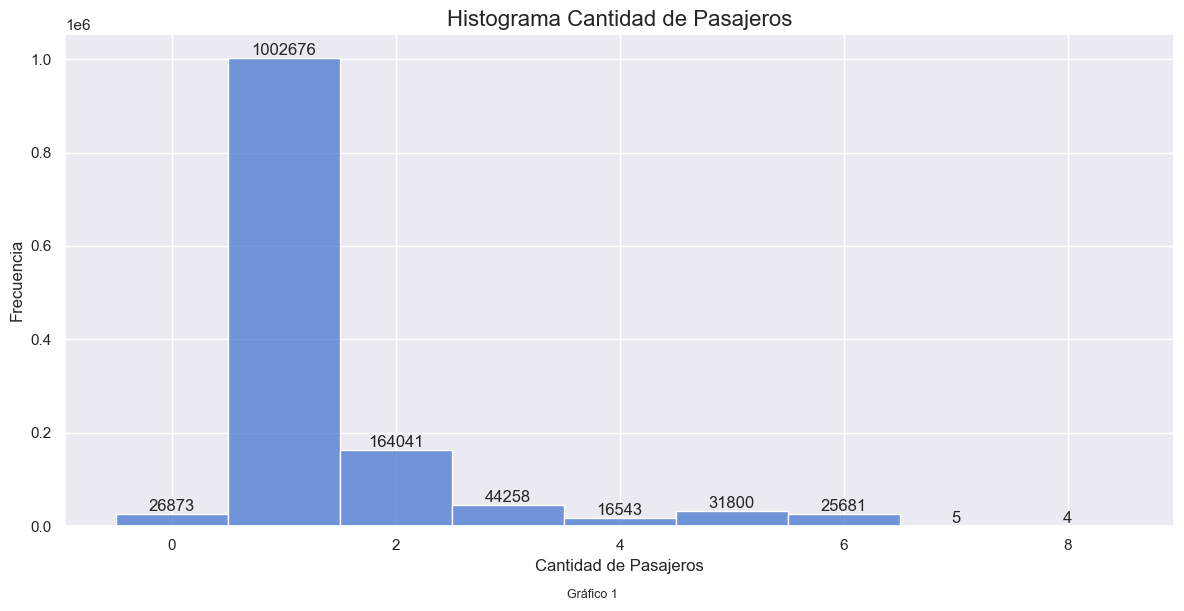

In [20]:
# # Histograma Cantidad de Pasajeros
bin_edges = range(int(df['passenger_count'].min()) - 1, int(df['passenger_count'].max()) + 2)
plt.figure(figsize=(12, 6))
ax = sns.histplot(df['passenger_count'], bins=bin_edges, discrete=True)
plt.title('Histograma Cantidad de Pasajeros', fontsize=16)
plt.xlabel('Cantidad de Pasajeros', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.figtext(0.5, -0.01, "Gráfico 1", wrap=True, horizontalalignment='center', fontsize=9)
ax.bar_label(ax.containers[0], fmt='%d', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show() 

- Se reemplazan los valors con 0 pasajeros por un nulo para que no afecten funciones de agregación.

In [21]:
#Se reemplazan valores 0 por nulos
df['passenger_count'] = df['passenger_count'].replace(0, np.nan)

### Gráfico 2: Cantidad de Viajes por Industria
- 82% de los viajes se producen en la industria FHV - High Volume

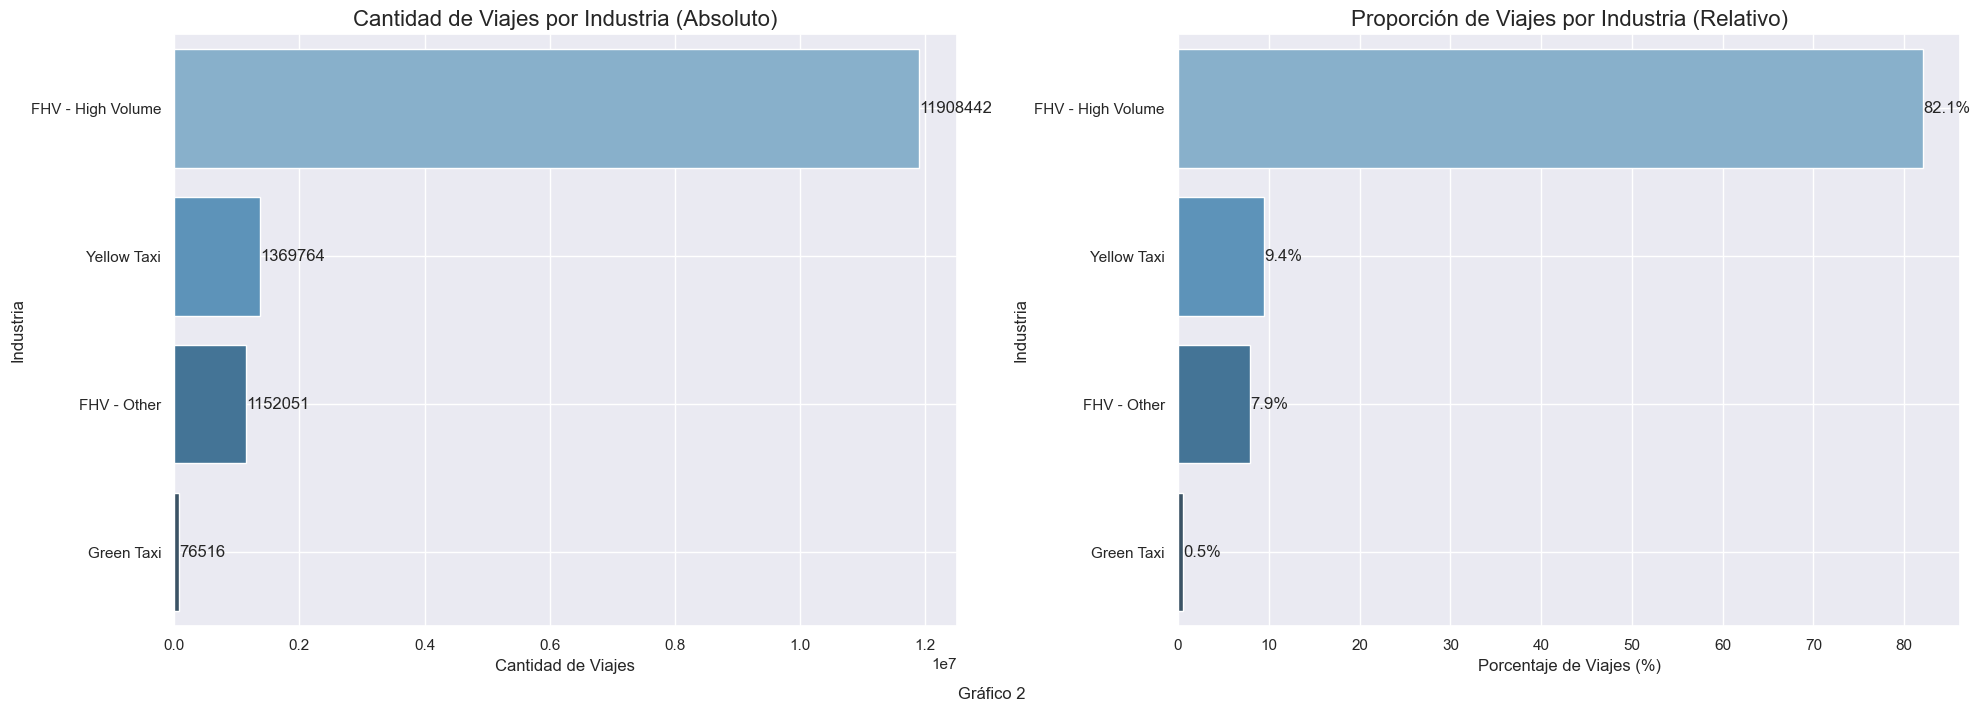

In [22]:
# # Cantidad de víctimas po Tipo de Calle
viajes_por_industria = df.groupby('industry').size().reset_index(name='Cantidad de Viajes')
viajes_por_industria = viajes_por_industria.sort_values('Cantidad de Viajes', ascending=False)
viajes_por_industria['Porcentaje'] = (viajes_por_industria['Cantidad de Viajes'] / viajes_por_industria['Cantidad de Viajes'].sum()) * 100

plt.figure(figsize=(20, 7))

# Primer gráfico: Cantidad absoluta de vijaes por industria
plt.subplot(1, 2, 1)
ax1 = sns.barplot(x='Cantidad de Viajes', y='industry', data=viajes_por_industria, palette='Blues_d')
plt.title('Cantidad de Viajes por Industria (Absoluto)', fontsize=16)
plt.xlabel('Cantidad de Viajes', fontsize=12)
plt.ylabel('Industria', fontsize=12)
for i in ax1.containers:
    ax1.bar_label(i, fmt='%d', fontsize=12)
plt.grid(True)

# Segundo gráfico: Proporción de viajes por industria
plt.subplot(1, 2, 2)
ax2 = sns.barplot(x='Porcentaje', y='industry', data=viajes_por_industria, palette='Blues_d')
plt.title('Proporción de Viajes por Industria (Relativo)', fontsize=16)
plt.xlabel('Porcentaje de Viajes (%)', fontsize=12)
plt.ylabel('Industria', fontsize=12)
for i in ax2.containers:
    ax2.bar_label(i, fmt='%.1f%%', fontsize=12)
plt.grid(True)

plt.figtext(0.5, -0.01, "Gráfico 2", wrap=True, horizontalalignment='center', fontsize=12)

plt.tight_layout()
plt.show()

### Gráfico 3: Histograma de Distancia
- Se identifica la presencia de outliers.
- No puede haber distancia 0.
- Se aplica la metodología por rangos intercuartílicos ya que es los valores extremos son muy elevados y alejados de la media. Se pone un límite en 0 ya que los valores nunca pueden ser negativos.

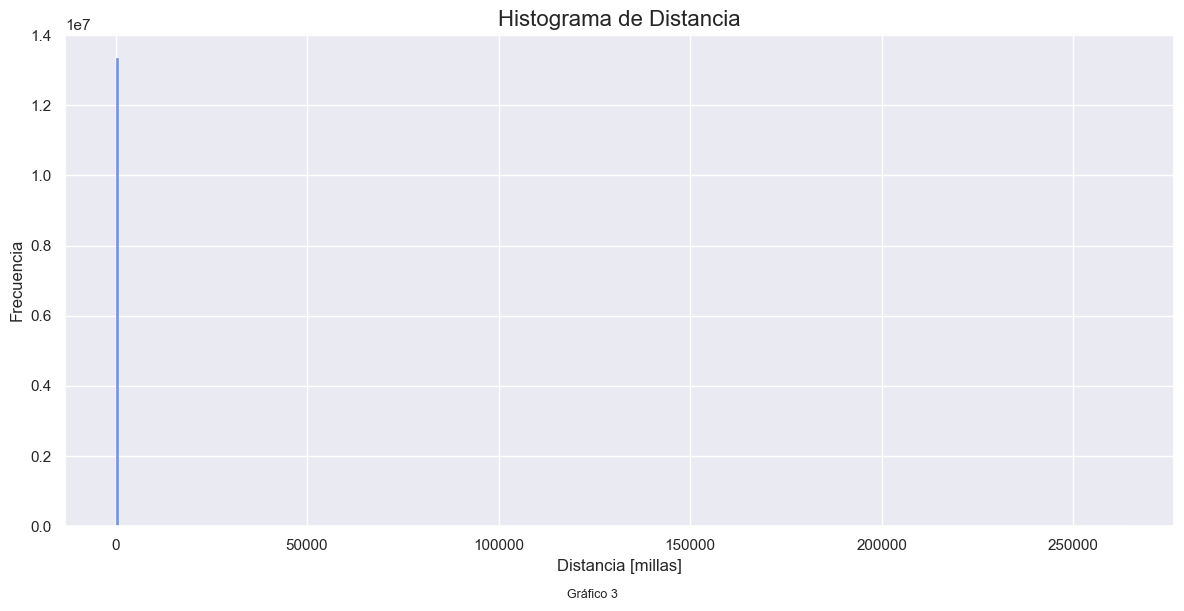

count    1.335472e+07
mean     4.732844e+00
std      1.927774e+02
min      0.000000e+00
25%      1.480000e+00
50%      2.680000e+00
75%      5.320000e+00
max      2.631633e+05
Name: trip_distance, dtype: float64

In [23]:
# # Cantidad de Viajes por Distancia
plt.figure(figsize=(12, 6))
ax = sns.histplot(df['trip_distance'], bins=300)
plt.title('Histograma de Distancia', fontsize=16)
plt.xlabel('Distancia [millas]', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.figtext(0.5, -0.01, "Gráfico 3", wrap=True, horizontalalignment='center', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show() 

df['trip_distance'].describe()

- Eliminación de outliers por método de Rango Intercuartílico con mínimo en 0.01. Se reemplazan los valores por nulos pero no se eliminan del dataset ya que cuentan para la cantidad de viajes.

In [24]:
# Eliminación de outliers por método de Rango Intercuartílico con mínimo en 0.01.
# Se reemplazan los valores por nulos pero no se eliminan del dataset ya que cuentan para la cantidad de viajes.
Q1 = df['trip_distance'].quantile(0.25)
Q3 = df['trip_distance'].quantile(0.75)
IQR = Q3 - Q1
df['trip_distance'] = np.where( (df['trip_distance'] < max(0.01,  Q1 - 1.5 * IQR)) | (df['trip_distance'] > Q3 + 1.5 * IQR), np.nan,
    df['trip_distance'])

- Se completan los datos faltantes con los valores de distancia promedio entre pickup_locations_id y dropoff_locations_id

In [25]:
# Elimino los registros con nulos en pickup o dropoff
df_cleaned = df.dropna(subset=['pickup_location_id', 'dropoff_location_id'])

# Calcuo la distancia promedio por combinación de pickup_location_id y dropoff_location_id
distancia_promedio = df_cleaned.groupby(['pickup_location_id', 'dropoff_location_id'])['trip_distance'].mean().reset_index()
distancia_promedio.columns = ['pickup_location_id', 'dropoff_location_id', 'promedio_distancia']

# Combino el DataFrame original con el DataFrame de distancia promedio
df = df_cleaned.merge(distancia_promedio, on=['pickup_location_id', 'dropoff_location_id'], how='left')

# Relleno los valores nulos en trip_distance con la distancia promedio
df['trip_distance'] = df['trip_distance'].fillna(df['promedio_distancia'])

# Elimino la columna temporal de promedio de distancia
df.drop(columns=['promedio_distancia'], inplace=True)

### Gráfico 4: Histograma de Tarifa Base
- Se identifica la presencia de outliers y valores negativos
- Se aplica la metodología por rangos intercuartílicos ya que es los valores extremos son muy elevados y alejados de la media. Se pone un límite en 0 ya que los valores nunca pueden ser negativos.

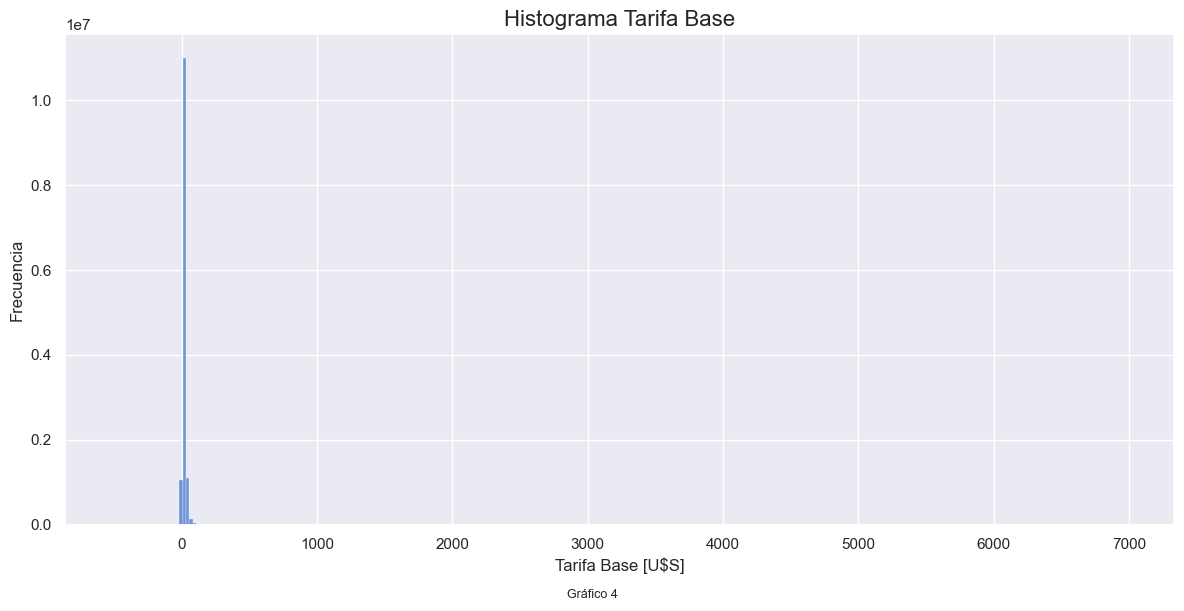

count    1.335472e+07
mean     1.668596e+01
std      1.331356e+01
min     -4.900000e+02
25%      8.450000e+00
50%      1.273000e+01
75%      2.058000e+01
max      6.960500e+03
Name: fare_amount, dtype: float64

In [26]:
# # Cantidad de Viajes por Tarifa Base
plt.figure(figsize=(12, 6))
ax = sns.histplot(df['fare_amount'], bins=300)
plt.title('Histograma Tarifa Base', fontsize=16)
plt.xlabel('Tarifa Base [U$S]', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.figtext(0.5, -0.01, "Gráfico 4", wrap=True, horizontalalignment='center', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show() 

df['fare_amount'].describe()

- Eliminación de outliers por método de Rango Intercuartílico con mínimo en 0.01. Se reemplazan los valores por nulos pero no se eliminan del dataset ya que cuentan para la cantidad de viajes.

In [27]:
# Eliminación de outliers por método de Rango Intercuartílico con mínimo en 0.01.
# Se reemplazan los valores por nulos pero no se eliminan del dataset ya que cuentan para la cantidad de viajes.
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1
df['fare_amount'] = np.where( (df['fare_amount'] < max(0.01,  Q1 - 1.5 * IQR)) | (df['fare_amount'] > Q3 + 1.5 * IQR), np.nan,
    df['fare_amount'])

### Gráfico 5 y 6: Histogramas de Distancia y Tarifa Base sin Outliers

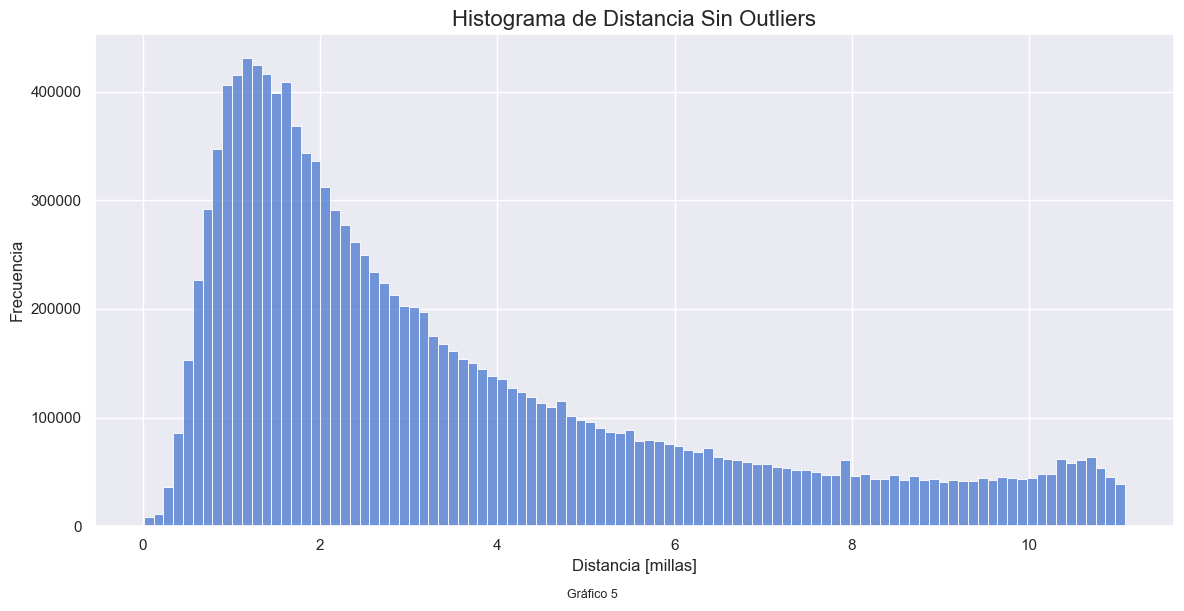

count    1.303743e+07
mean     3.518116e+00
std      2.713702e+00
min      1.000000e-02
25%      1.450000e+00
50%      2.562000e+00
75%      4.850000e+00
max      1.108000e+01
Name: trip_distance, dtype: float64

In [28]:
# # Cantidad de Viajes por Distancia Sin Outliers
plt.figure(figsize=(12, 6))
ax = sns.histplot(df['trip_distance'],bins = 100) #, kde=True
plt.title('Histograma de Distancia Sin Outliers', fontsize=16)
plt.xlabel('Distancia [millas]', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.figtext(0.5, -0.01, "Gráfico 5", wrap=True, horizontalalignment='center', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show() 

df['trip_distance'].describe()

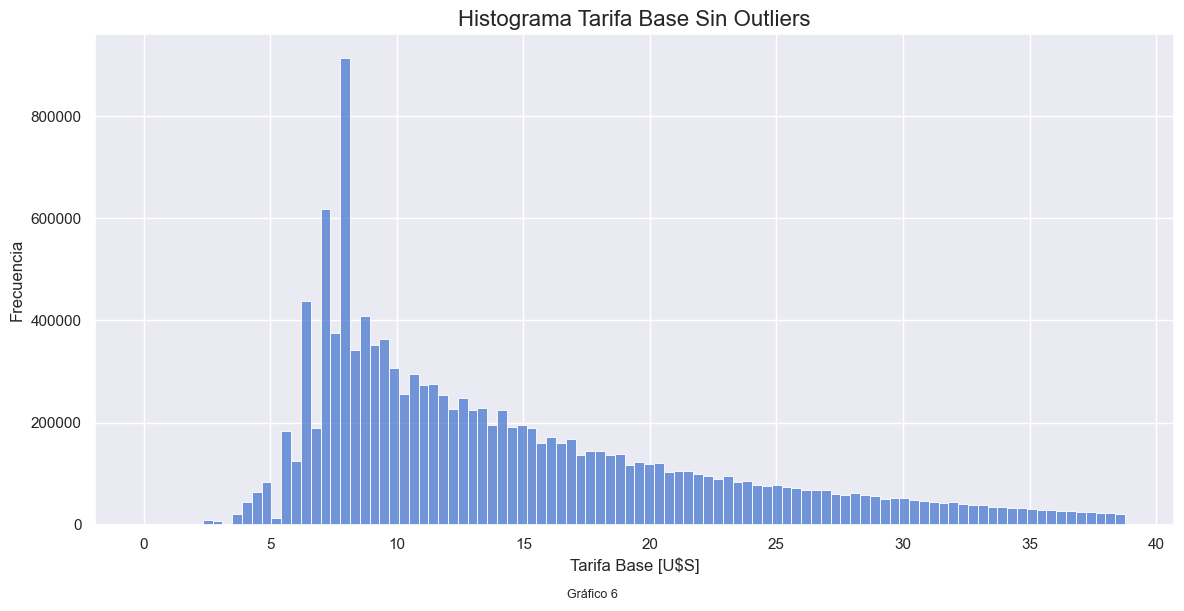

count    1.261515e+07
mean     1.455932e+01
std      7.823547e+00
min      1.000000e-02
25%      8.230000e+00
50%      1.218000e+01
75%      1.890000e+01
max      3.877000e+01
Name: fare_amount, dtype: float64

In [29]:
# # Cantidad de Viajes por Tarifa Base Sin Outliers
plt.figure(figsize=(12, 6))
ax = sns.histplot(df['fare_amount'],bins = 100) #, kde=True
plt.title('Histograma Tarifa Base Sin Outliers', fontsize=16)
plt.xlabel('Tarifa Base [U$S]', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.figtext(0.5, -0.01, "Gráfico 6", wrap=True, horizontalalignment='center', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show() 

df['fare_amount'].describe()

### Gráfico 7: Histograma de Tarifa Total
- Hay valores negativos, por lo que se pasan a nulos.
- Se observa que podrían haber algunos outliers, se decide correlacionar con Tarifa Base para determinar si esto es así.

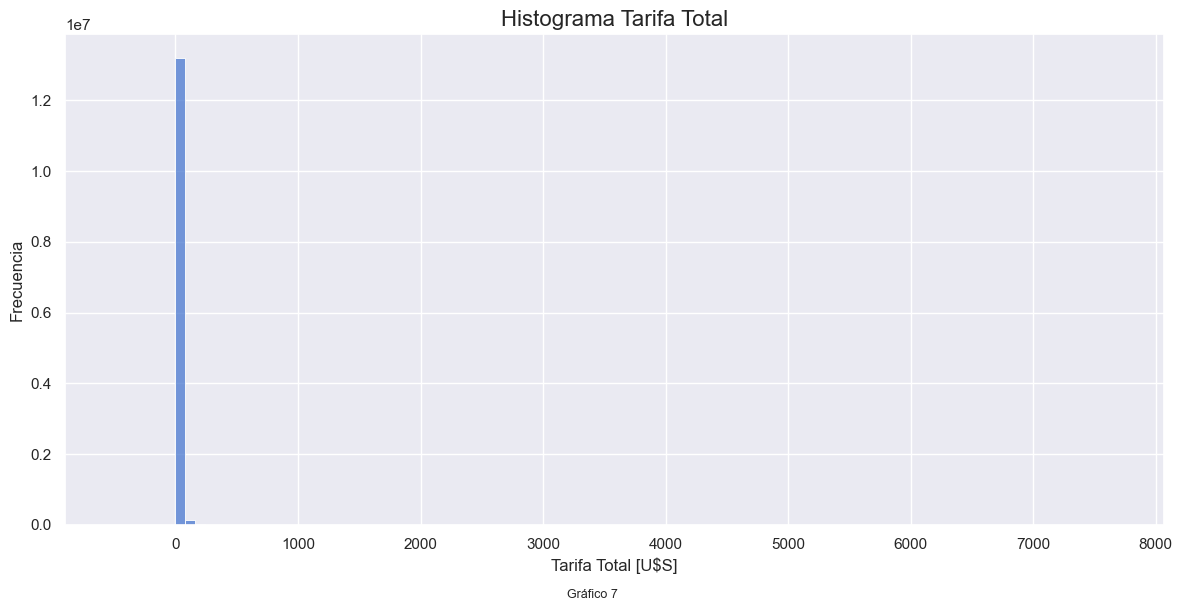

count    1.261515e+07
mean     1.455932e+01
std      7.823547e+00
min      1.000000e-02
25%      8.230000e+00
50%      1.218000e+01
75%      1.890000e+01
max      3.877000e+01
Name: fare_amount, dtype: float64

In [30]:
# Cantidad de Viajes por Tarifa Total
plt.figure(figsize=(12, 6))
ax = sns.histplot(df['total_amount'],bins = 100)
plt.title('Histograma Tarifa Total', fontsize=16)
plt.xlabel('Tarifa Total [U$S]', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.figtext(0.5, -0.01, "Gráfico 7", wrap=True, horizontalalignment='center', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show() 

df['fare_amount'].describe()

In [31]:
# No puede haber valores negativos
df['total_amount'] = np.where(df['total_amount'] < 0, np.nan, df['total_amount'])

### Gráfico 8 y 9: Correlación entre Tarifa Base y Tarifa Total
- No puede haber valor de Tarifa Total si Tarifa Base es nulo.
- Se elabora una correlación contra Tarifa Base. Los valores de Tarifa Total muy alejados, podrían estar relacionados con Propinas elevadas.
- Si luego se debe realizar una estimación de Tarifa Total, no es útil tener valores que tengan una relación tan alejada con Tarifa Base, por lo que se excluirán valores.
- Se decide considerar el percentil 99.99% de los residuos de la correlación lineal. Si se utiliza el 99% se elimina mucha información que no parece ser outlier.

In [32]:
# Pongo nulo en total_amount si en fare_amount hay nulo
df.loc[df['fare_amount'].isna(), 'total_amount'] = np.nan

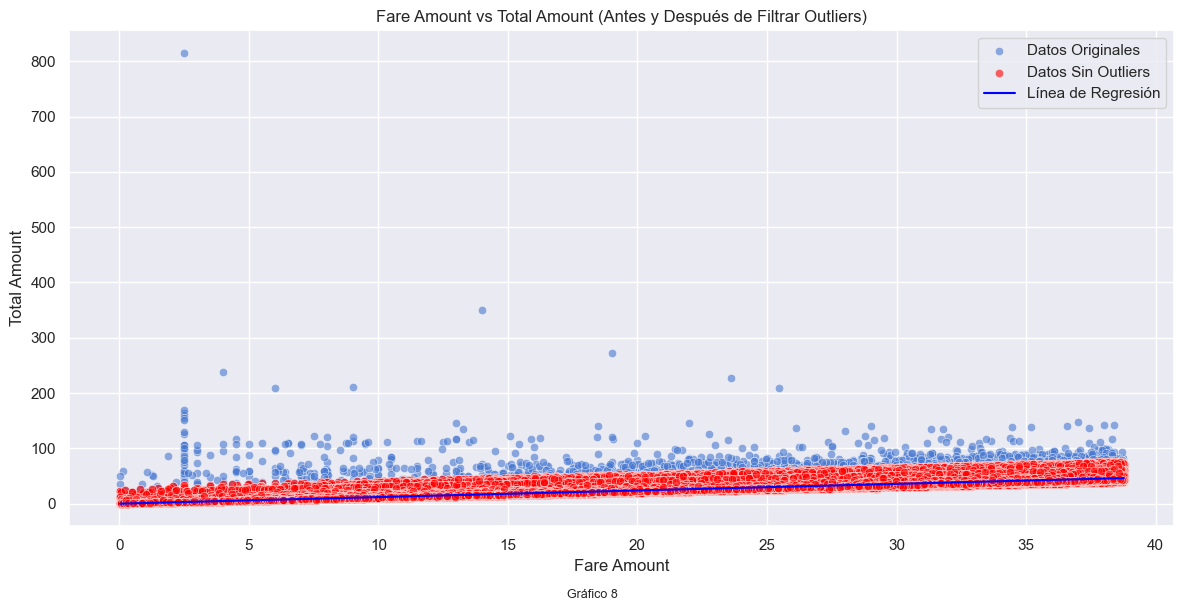

In [33]:
# Elimino los nulos
df_no_nan = df.dropna(subset=['fare_amount', 'total_amount'])

# Defino las variables a correlacional
X = df_no_nan[['fare_amount']]
y = df_no_nan['total_amount']

# Ajusto el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Predigo los valores de 'total_amount'
predictions = model.predict(X)

# Calculo los residuos
residuals = y - predictions

# Defino un umbral en el percentil 99% para identificar outliers
threshold = np.percentile(np.abs(residuals), 99.99)

# Índices donde el residuo supera el threshold
outlier_indices = df_no_nan.index[np.abs(residuals) > threshold]

# Pongo nulo cuando se supera el umbral en los índices que superaron el threshold
df.loc[outlier_indices, 'total_amount'] = np.nan

#--------------------------------
# Datos originales (sin eliminar outliers)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_no_nan, x='fare_amount', y='total_amount', label='Datos Originales', alpha=0.6)

# Datos filtrados con los outliers como nulo
sns.scatterplot(data=df, x='fare_amount', y='total_amount', label='Datos Sin Outliers', color='red', alpha=0.6)

# Línea de regresión
x_range = np.linspace(df_no_nan['fare_amount'].min(), df_no_nan['fare_amount'].max(), 100).reshape(-1, 1)
line_predictions = model.predict(x_range)
plt.plot(x_range, line_predictions, color='blue', label='Línea de Regresión')

# Ajustes finales del gráfico
plt.title('Fare Amount vs Total Amount (Antes y Después de Filtrar Outliers)')
plt.xlabel('Fare Amount')
plt.ylabel('Total Amount')
plt.figtext(0.5, -0.01, "Gráfico 8", wrap=True, horizontalalignment='center', fontsize=9)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Resultado sin outliers.

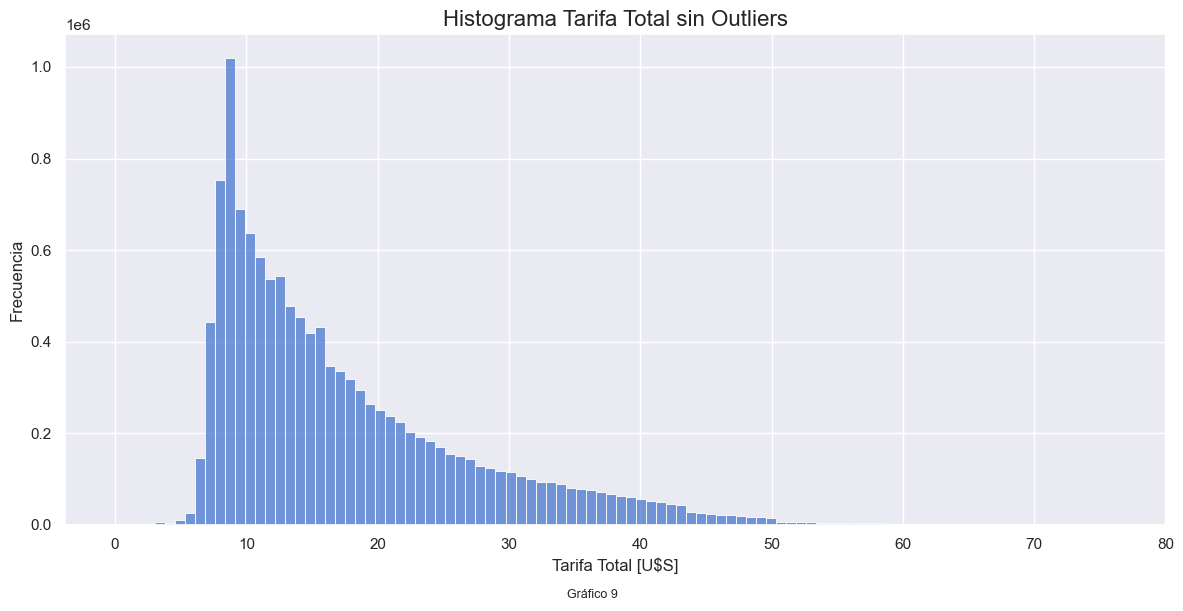

In [34]:
# Cantidad de Viajes por Tarifa Total
plt.figure(figsize=(12, 6))
ax = sns.histplot(df['total_amount'],bins = 100)
plt.title('Histograma Tarifa Total sin Outliers', fontsize=16)
plt.xlabel('Tarifa Total [U$S]', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.figtext(0.5, -0.01, "Gráfico 9", wrap=True, horizontalalignment='center', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show() 

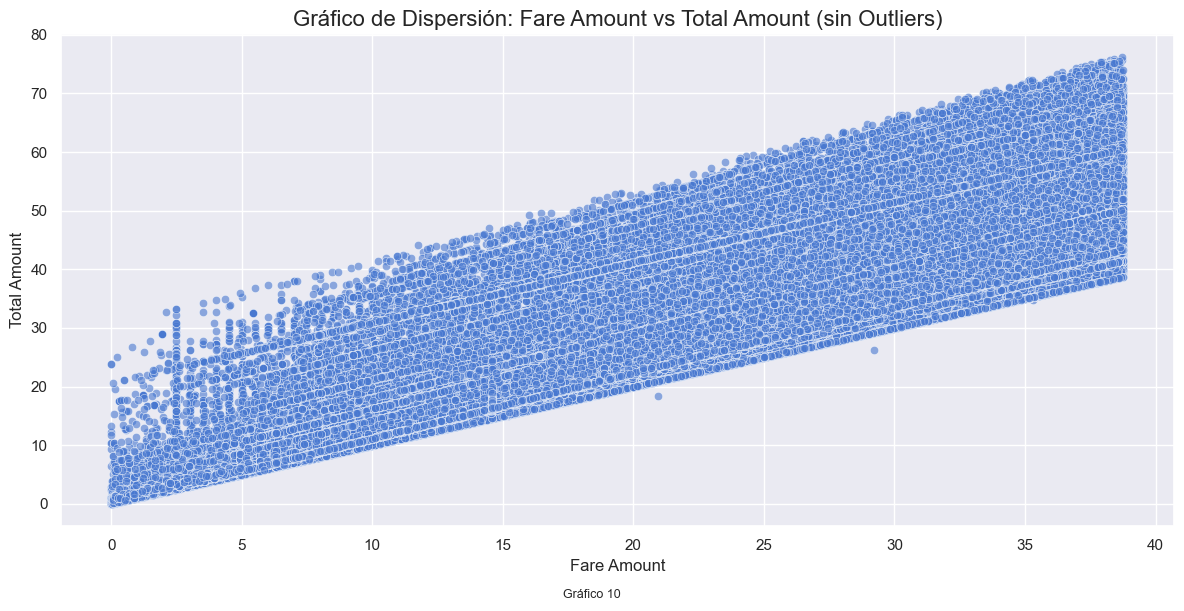

In [35]:
# Configurar el tamaño de la figura
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='fare_amount', y='total_amount', alpha=0.6)
plt.title('Gráfico de Dispersión: Fare Amount vs Total Amount (sin Outliers)', fontsize=16)
plt.xlabel('Fare Amount', fontsize=12)
plt.ylabel('Total Amount', fontsize=12)
plt.figtext(0.5, -0.01, "Gráfico 10", wrap=True, horizontalalignment='center', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

### Gráfico 11: Histograma de Tarifa de Congestión
- No puede haber valores negativos

In [36]:
# No puede haber valores negativos
df['congestion_surcharge'] = np.where(df['congestion_surcharge'] < 0, np.nan, df['congestion_surcharge'])

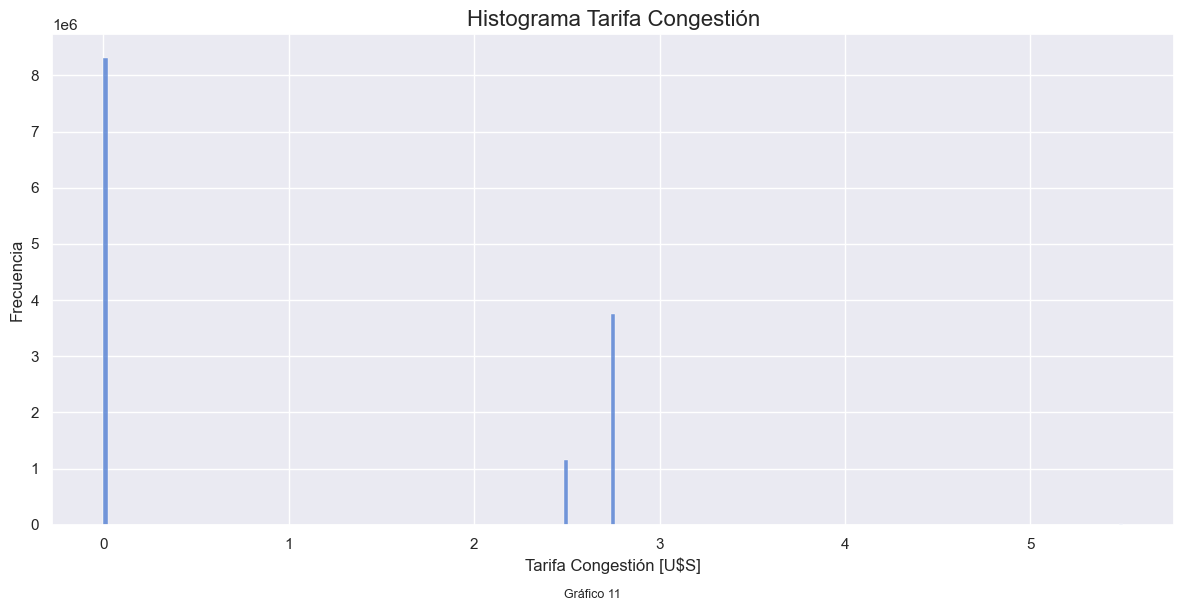

In [37]:
# Cantidad de Viajes por Tarifa Congestión
plt.figure(figsize=(12, 6))
ax = sns.histplot(df['congestion_surcharge'])
plt.title('Histograma Tarifa Congestión', fontsize=16)
plt.xlabel('Tarifa Congestión [U$S]', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.figtext(0.5, -0.01, "Gráfico 11", wrap=True, horizontalalignment='center', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show() 

### Gráfico 12: Proporción de viajes compartidos
- Se modifica el valor del flag shared_match_flag para contemplar los casos en que el viaje tuvo más de un pasajero.
- Se observa que sólo el 2% de los viajes son compartidos.
- Esto podría tener gran implicancia en la reducción de la huella de carbono.

In [38]:
# Configurar el valor de shared_match_flag basado en passenger_count
df['shared_match_flag'] = df['passenger_count'].apply(lambda x: True if x > 1 else False)

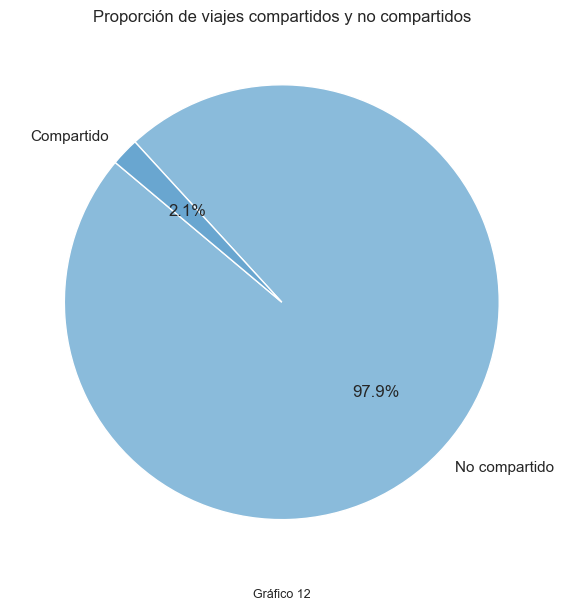

In [39]:
# Cuento la cantidad de viajes compartidos y no compartidos
shared_counts = df['shared_match_flag'].value_counts()

# Crear el gráfico de torta
plt.figure(figsize=(10, 6))
plt.pie(shared_counts, labels=['No compartido', 'Compartido'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Blues_d'))
plt.title('Proporción de viajes compartidos y no compartidos')
plt.figtext(0.5, -0.01, "Gráfico 12", wrap=True, horizontalalignment='center', fontsize=9)
plt.tight_layout()
plt.show() 

### Gráfico 13 y 14: Duración de los Viajes
- Hay valores negativos de tiempo. Son todos en el dataset de Taxis Amarillos. Tomo la decisión de invertir los valores de pickup_datatime y dropoff_datatime en este caso.
- Hay algunos valores extremos muy elevados. Para los outliers (percentil 99.9%) se modifica dropoff_datetime en función del valor medio de duración del viaje para la relación entre pickup_location_id y dropoff_location_id.

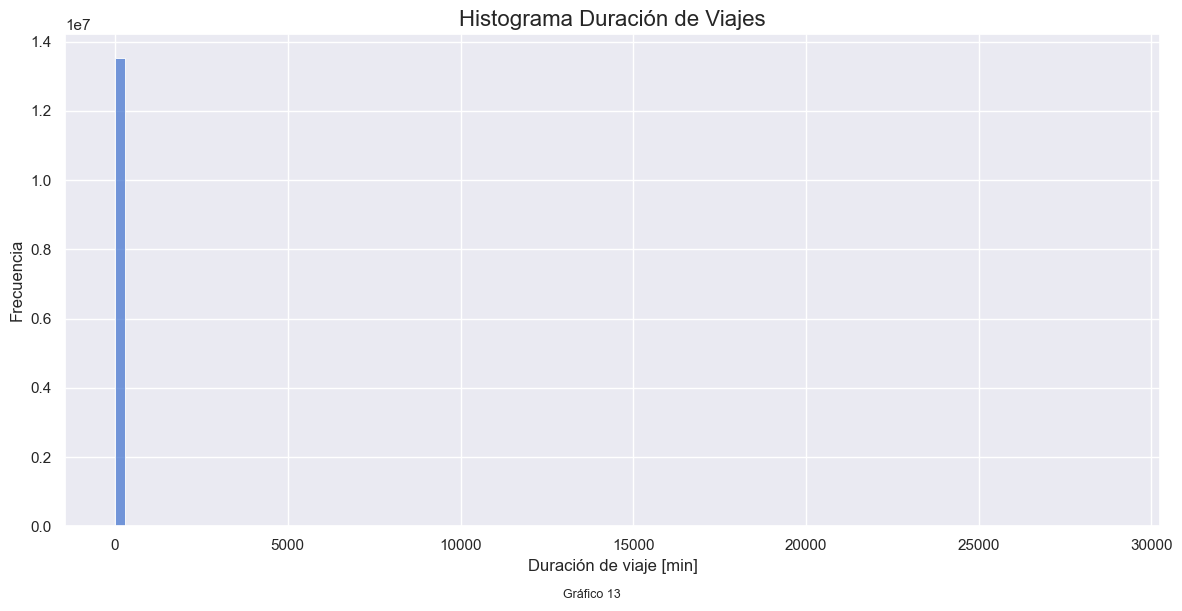

In [40]:
# Calculo duración del viaje en minutos
df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60

# Cantidad de Viajes por Tarifa Congestión
plt.figure(figsize=(12, 6))
ax = sns.histplot(df['trip_duration'], bins = 100)
plt.title('Histograma Duración de Viajes', fontsize=16)
plt.xlabel('Duración de viaje [min]', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.figtext(0.5, -0.01, "Gráfico 13", wrap=True, horizontalalignment='center', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show() 

In [41]:
df['trip_duration'].describe()

count    1.353873e+07
mean     1.581499e+01
std      2.312384e+01
min     -4.216667e+00
25%      8.333333e+00
50%      1.298333e+01
75%      1.986667e+01
max      2.881770e+04
Name: trip_duration, dtype: float64

In [42]:
# Cuento los registros agrupados por industria
negative_duration_count = df[df['trip_duration'] < 0].groupby('industry').size().reset_index(name='count')
print(negative_duration_count)

      industry  count
0  Yellow Taxi   5641


In [43]:
df[df['trip_duration'] <0].head()

,industry,pickup_datetime,dropoff_datetime,pickup_location_id,dropoff_location_id,passenger_count,trip_distance,payment_type,fare_amount,total_amount,congestion_surcharge,shared_request_flag,shared_match_flag,trip_duration
151936,Yellow Taxi,2021-01-05 17:43:19,2021-01-05 17:39:06,145,145,1,1.100449,2,4.00,5.80,0.0,<NA>,False,-4.216667
1271419,Yellow Taxi,2021-01-01 00:01:06,2021-01-01 00:01:02,265,108,<NA>,9.230000,0,33.73,34.53,NaN,<NA>,False,-0.066667
1271436,Yellow Taxi,2021-01-01 00:01:14,2021-01-01 00:01:02,265,69,<NA>,4.100000,0,16.52,17.32,NaN,<NA>,False,-0.200000
1271459,Yellow Taxi,2021-01-01 00:01:08,2021-01-01 00:01:03,265,35,<NA>,4.212741,0,31.45,32.25,NaN,<NA>,False,-0.083333
1271479,Yellow Taxi,2021-01-01 00:01:59,2021-01-01 00:01:03,265,200,<NA>,3.880000,0,15.20,16.00,NaN,<NA>,False,-0.933333


- Se invierten los datos de tiempo en caso de que la duración sea negativa.

In [44]:
# Mácara donde dropoff_datetime es menor que pickup_datetime
mask = df['dropoff_datetime'] < df['pickup_datetime']
# Intercambio los valores en esas filas
df.loc[mask, ['pickup_datetime', 'dropoff_datetime']] = df.loc[mask, ['dropoff_datetime', 'pickup_datetime']].values
# Recalculo la duración
df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60

- Para los outliers (percentil 99.9%) se modifica dropoff_datetime en función del valor medio de duración del viaje para la relación entre pickup_location_id y dropoff_location_id.

In [45]:
# Se define el límite de valores de tiempo de viaje superiores a al percentil 99%
Limit = df['trip_duration'].quantile(.999)
duration_count_99 = df[df['trip_duration'] > Limit].groupby('industry').size().reset_index(name='count')
print(duration_count_99)

# Calculo la duración media de trip_duration por combinación de pickup y dropoff location
mean_duration_by_location = (
    df.groupby(['pickup_location_id', 'dropoff_location_id'])['trip_duration']
    .mean()
    .reset_index()
    .rename(columns={'trip_duration': 'mean_trip_duration'})
)

# Uno el promedio de duración con el DataFrame original para usarlo en el reemplazo
df = df.merge(mean_duration_by_location, on=['pickup_location_id', 'dropoff_location_id'], how='left')

# Reemplazo los valores de dropoff_datetime fuera del límite con pickup_datetime + mean_trip_duration
df.loc[df['trip_duration'] > Limit, 'dropoff_datetime'] = (
    df['pickup_datetime'] + pd.to_timedelta(df['mean_trip_duration'], unit='s')
)

# Elimino la columna auxiliar 'mean_trip_duration'
df.drop(columns='mean_trip_duration', inplace=True)

# Recalculo la duración
df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60

            industry  count
0  FHV - High Volume   7795
1        FHV - Other   2403
2         Green Taxi    351
3        Yellow Taxi   2988


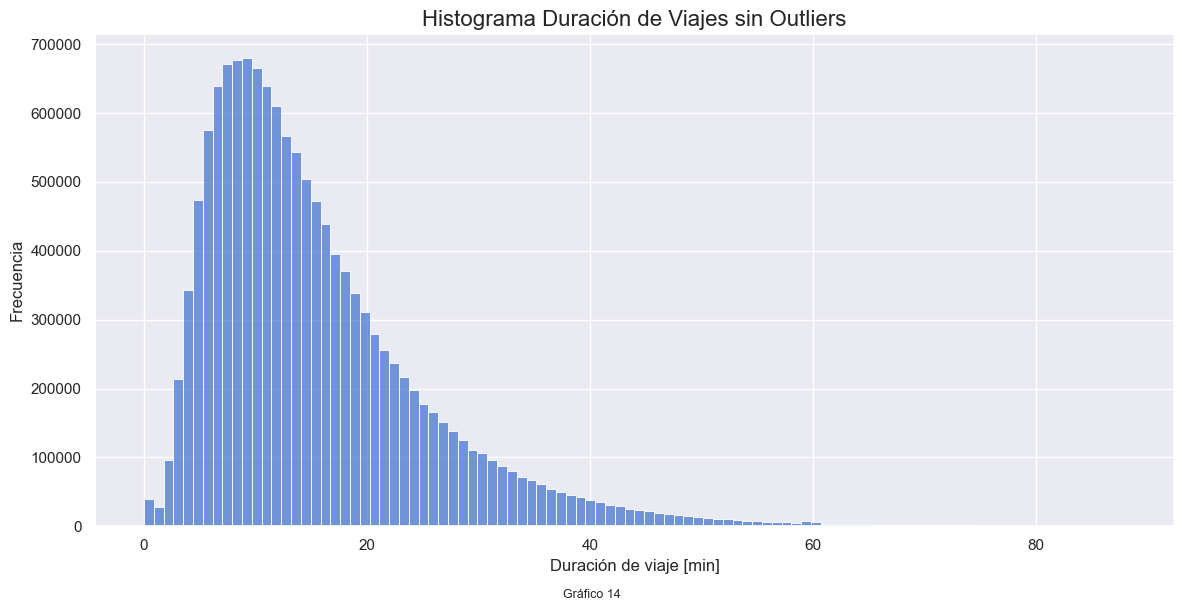

In [46]:
# Cantidad de Viajes por Tarifa Congestión
plt.figure(figsize=(12, 6))
ax = sns.histplot(df['trip_duration'], bins = 100)
plt.title('Histograma Duración de Viajes sin Outliers', fontsize=16)
plt.xlabel('Duración de viaje [min]', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.figtext(0.5, -0.01, "Gráfico 14", wrap=True, horizontalalignment='center', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show() 

### Gráfico 15: Mapa de calor de pickups y dropoffs por Zona
- Las principales zonas de pickup y dropoff coinciden.
- Los principale Borough son Mahattan y Brooklin

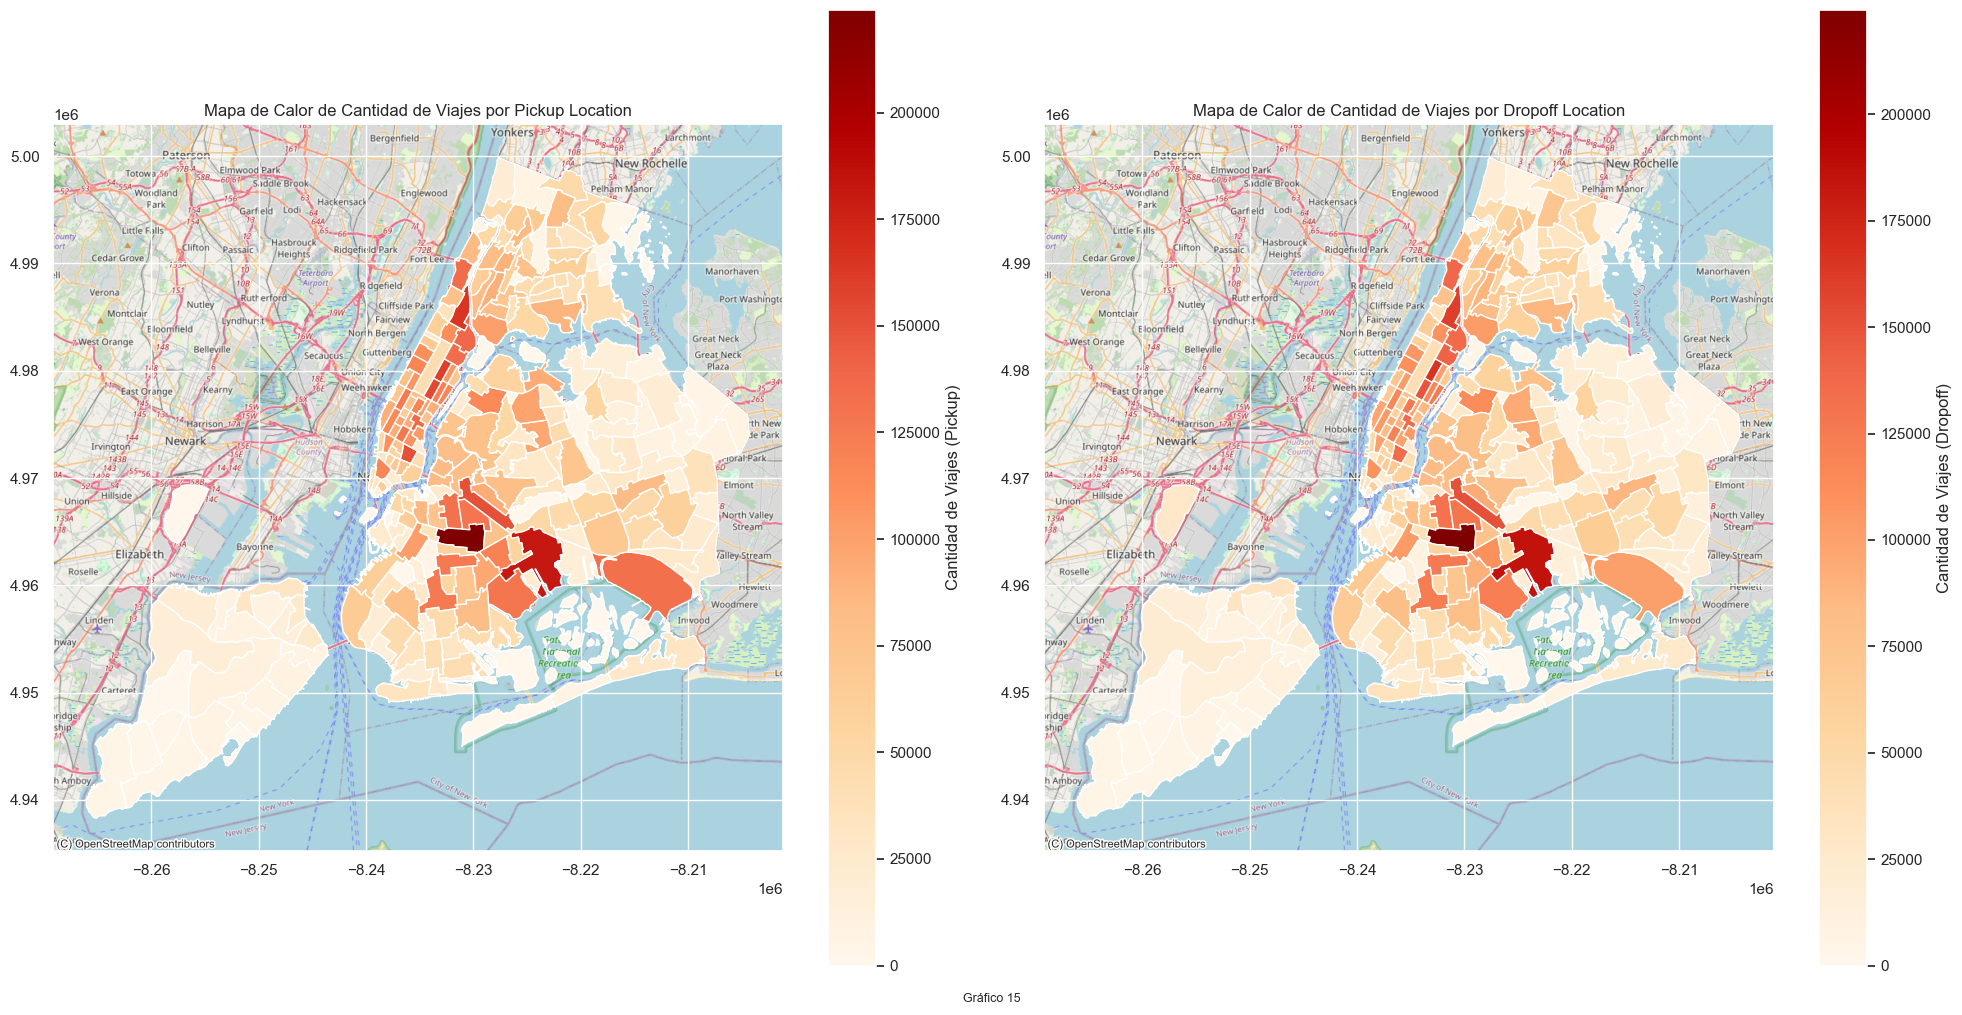

In [47]:
# Cargo el archivo de zonas de Nueva York
ny_zones = gpd.read_file("..\\datasets\\1. Originales\\taxi_zones\\taxi_zones.shp")

# Cuento cantidad de viajes por pickup_location_id y dropoff_location_id
pickup_counts = df['pickup_location_id'].value_counts().reset_index()
pickup_counts.columns = ['LocationID', 'pickup_count']

dropoff_counts = df['dropoff_location_id'].value_counts().reset_index()
dropoff_counts.columns = ['LocationID', 'dropoff_count']

# Uno los df con las zonas de Nueva York para obtener la geometría
ny_zones_pickup = ny_zones.merge(pickup_counts, on='LocationID', how='left')
ny_zones_dropoff = ny_zones.merge(dropoff_counts, on='LocationID', how='left')

# Reemplazo nulos por 0 para zonas sin viajes
ny_zones_pickup['pickup_count'] = ny_zones_pickup['pickup_count'].fillna(0)
ny_zones_dropoff['dropoff_count'] = ny_zones_dropoff['dropoff_count'].fillna(0)

# Convierto la proyección a Web Mercator (EPSG:3857) para utilizar contextily
ny_zones_pickup = ny_zones_pickup.to_crs(epsg=3857)
ny_zones_dropoff = ny_zones_dropoff.to_crs(epsg=3857)

# Creo la figura con dos gráficos
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))

# Primer mapa: Mapa de calor de cantidad de viajes por pickup_location_id
ny_zones_pickup.plot(column='pickup_count', ax=ax1, cmap='OrRd', legend=True,
                     legend_kwds={'label': "Cantidad de Viajes (Pickup)", 'orientation': "vertical"})
# Agrego mapa base
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)
ax1.set_title("Mapa de Calor de Cantidad de Viajes por Pickup Location")

# Segundo mapa: Mapa de calor de cantidad de viajes por dropoff_location_id
ny_zones_dropoff.plot(column='dropoff_count', ax=ax2, cmap='OrRd', legend=True,
                      legend_kwds={'label': "Cantidad de Viajes (Dropoff)", 'orientation': "vertical"})
# Agrego mapa base
ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik)
ax2.set_title("Mapa de Calor de Cantidad de Viajes por Dropoff Location")

plt.figtext(0.5, -0.01, "Gráfico 15", wrap=True, horizontalalignment='center', fontsize=9)
plt.tight_layout()
plt.show()

### Gráfico 16: Matriz de correlación
- Se verifica alta correlación entre, 
    - trip_distance con fare_amount y total_amount
    - trip_duration con fare_amount y total_amount

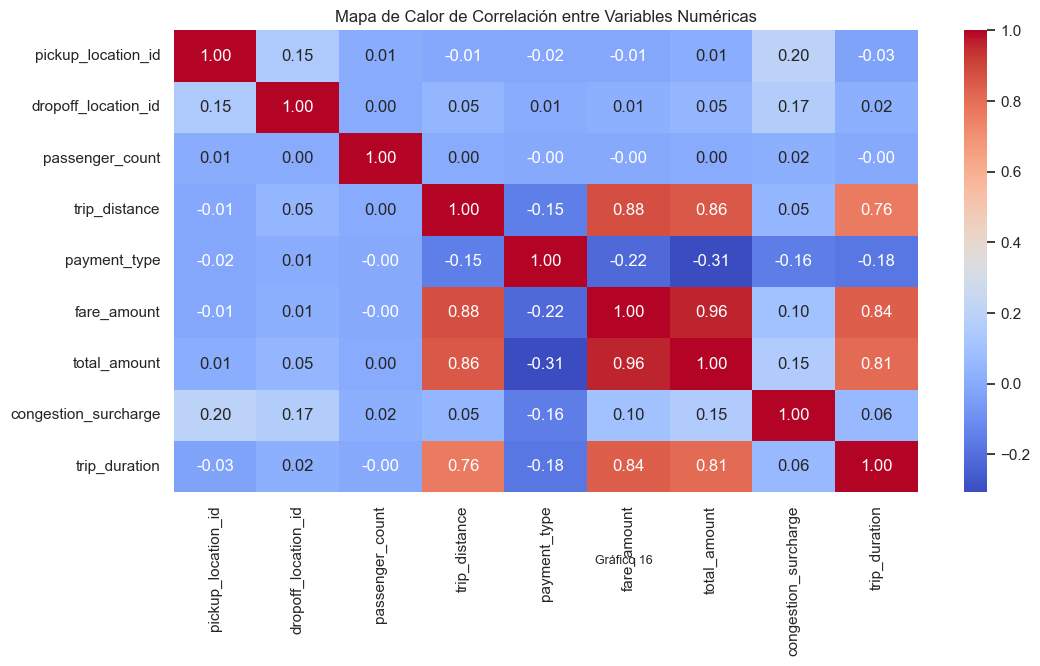

In [48]:
# Filtrar solo las columnas numéricas
numeric_df = df.select_dtypes(include=['number'])

# Calcular la matriz de correlación
correlation_matrix = numeric_df.corr()

# Crear un mapa de calor
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Mapa de Calor de Correlación entre Variables Numéricas")
plt.figtext(0.5, -0.01, "Gráfico 16", wrap=True, horizontalalignment='center', fontsize=9)
plt.show()


### Análisis temporal:

In [49]:
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day_of_week'] = df['pickup_datetime'].dt.day_name()
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week_num'] = df['pickup_datetime'].dt.day

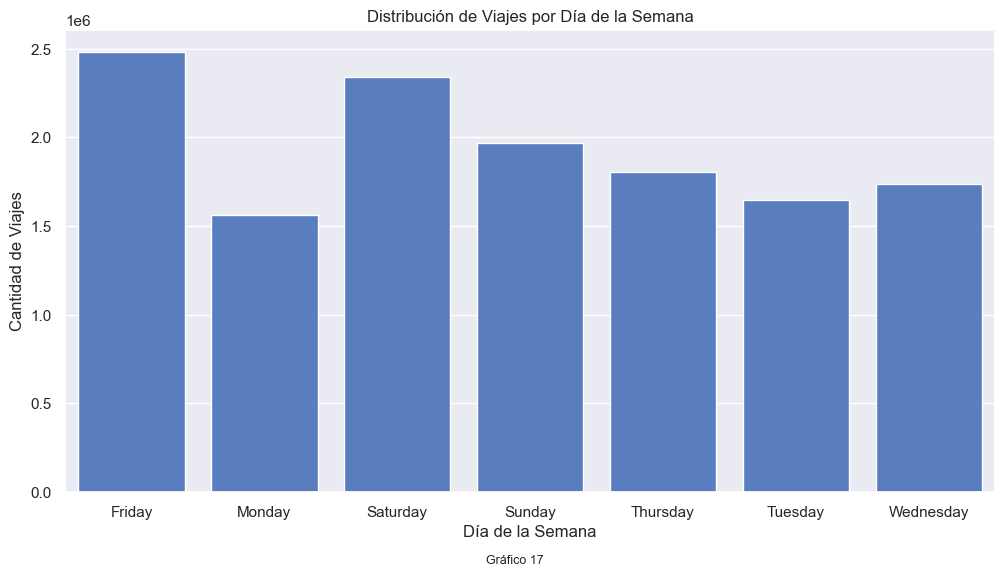

In [50]:
# Distribución por día de la semana:
viajes_por_dia = df['day_of_week'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.barplot(x=viajes_por_dia.index, y=viajes_por_dia.values)
plt.title('Distribución de Viajes por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Cantidad de Viajes')
plt.figtext(0.5, -0.01, "Gráfico 17", wrap=True, horizontalalignment='center', fontsize=9)
plt.show()

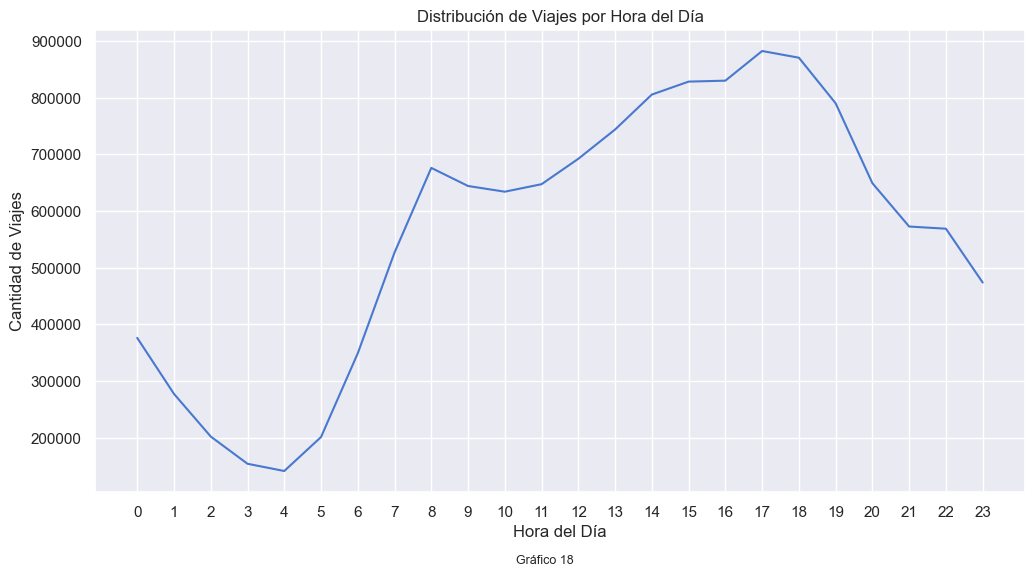

In [51]:
# Distribución horaria:
viajes_por_hora = df['hour'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x=viajes_por_hora.index, y=viajes_por_hora.values)
plt.title('Distribución de Viajes por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Cantidad de Viajes')
plt.xticks(range(24))
plt.figtext(0.5, -0.01, "Gráfico 18", wrap=True, horizontalalignment='center', fontsize=9)
plt.show()

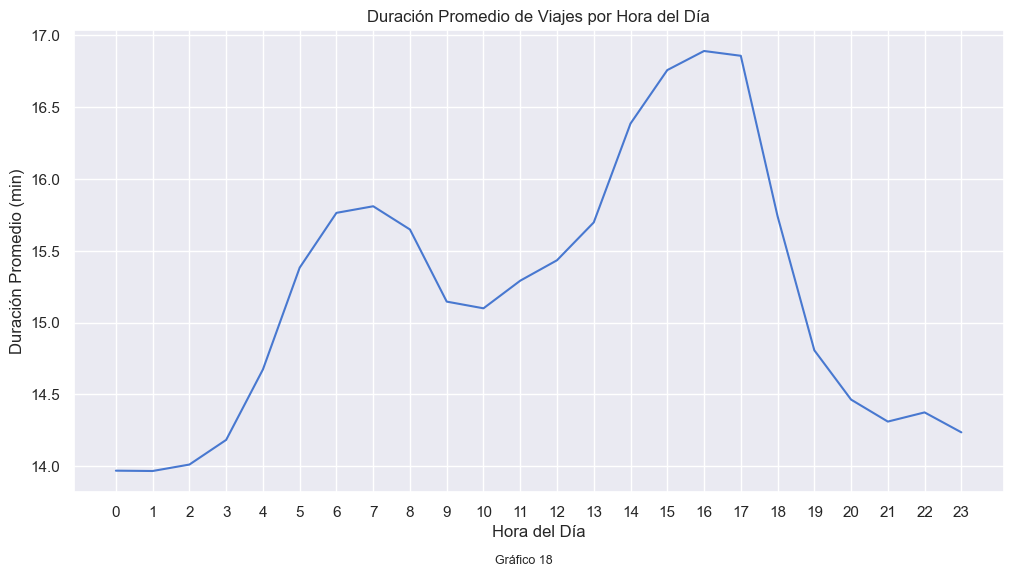

In [52]:
# Análisis de la Duración de los Viajes a lo Largo del Día
duracion_por_hora = df.groupby('hour')['trip_duration'].mean()
plt.figure(figsize=(12, 6))
sns.lineplot(x=duracion_por_hora.index, y=duracion_por_hora.values)
plt.title('Duración Promedio de Viajes por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Duración Promedio (min)')
plt.figtext(0.5, -0.01, "Gráfico 18", wrap=True, horizontalalignment='center', fontsize=9)
plt.xticks(range(24))
plt.show()

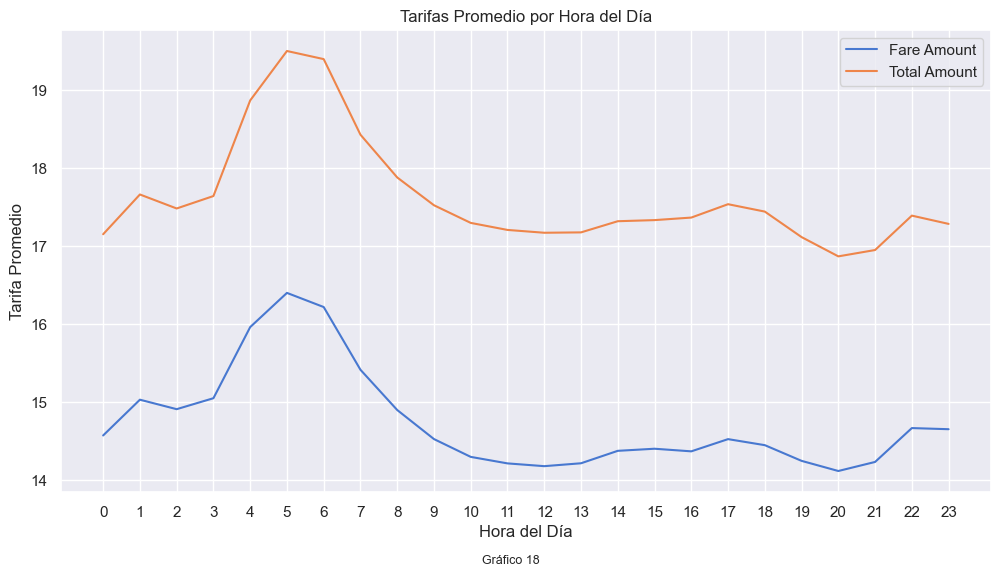

In [53]:
# Análisis de Tarifas a lo Largo del Tiempo
tarifas_por_hora = df.groupby('hour')[['fare_amount', 'total_amount']].mean()
tarifas_por_hora.plot(figsize=(12, 6))
plt.title('Tarifas Promedio por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Tarifa Promedio')
plt.legend(['Fare Amount', 'Total Amount'])
plt.figtext(0.5, -0.01, "Gráfico 18", wrap=True, horizontalalignment='center', fontsize=9)
plt.xticks(range(24))
plt.grid(True)
plt.show()

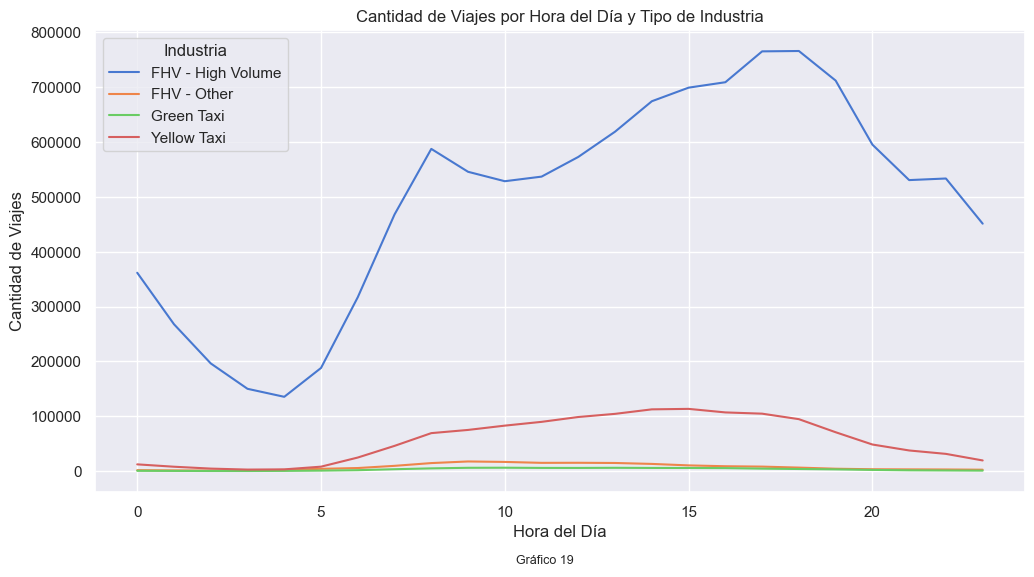

In [54]:
# Comparación de la Actividad entre Tipos de Industria

viajes_por_industria_hora = df.groupby(['hour', 'industry']).size().unstack()
viajes_por_industria_hora.plot(kind='line', figsize=(12, 6))
plt.title('Cantidad de Viajes por Hora del Día y Tipo de Industria')
plt.xlabel('Hora del Día')
plt.ylabel('Cantidad de Viajes')
plt.legend(title='Industria')
plt.figtext(0.5, -0.01, "Gráfico 19", wrap=True, horizontalalignment='center', fontsize=9)
plt.grid(True)
plt.show()

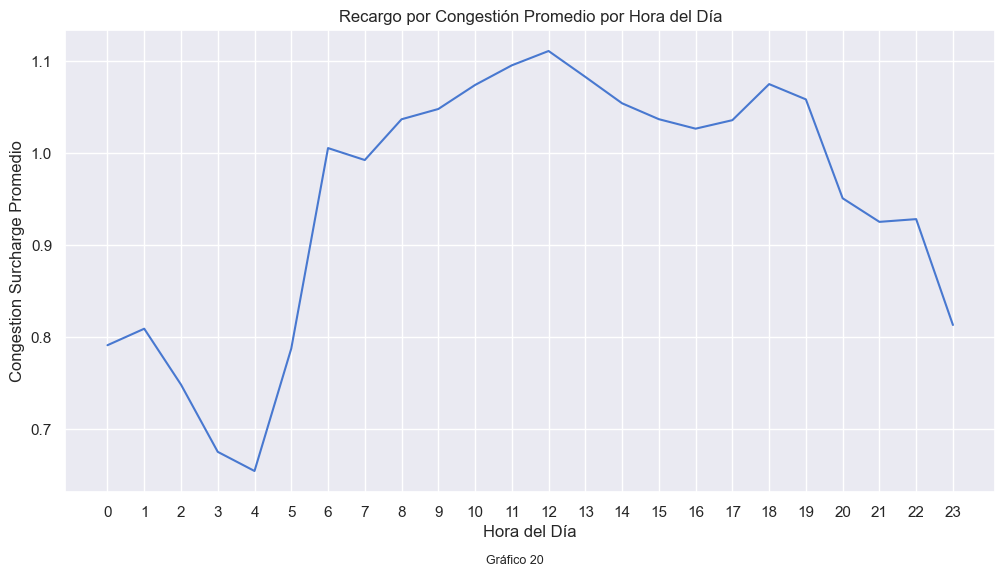

In [55]:
# Análisis de Congestión (Surcharge)
congestion_por_hora = df.groupby('hour')['congestion_surcharge'].mean()
plt.figure(figsize=(12, 6))
sns.lineplot(x=congestion_por_hora.index, y=congestion_por_hora.values)
plt.title('Recargo por Congestión Promedio por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Congestion Surcharge Promedio')
plt.xticks(range(24))
plt.figtext(0.5, -0.01, "Gráfico 20", wrap=True, horizontalalignment='center', fontsize=9)
plt.show()